## Project Statement 📄 : -
Model takes an abstract of any Reseach Paper and convert it into easily readable format by classifying and formating sequences of the abstract into five categories.

  1)Background 2)Objactives 3)Method 4)Conclusion 5) Result

## Benefit/Use case 🪴: -
This can help Applied Researchers/Students to go through abstract of different research papers quickly to get breif idea of it.

## Method 📜: -
Replicated the deep learning model mentioned in paper : [Deep Learning Model for joint sentence classification in medical paper abstracts.](https://arxiv.org/abs/1710.06071)

## Dataset 📚: -

Data taken from : [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.](https://arxiv.org/abs/1710.06071) 


## Experiment 🧪: -
Total 5 Experiments is implemented which are list below: -

1) model 0: Baseline model - TFIDF + Naive Bayes

2) model 1: custom token embeddings (TensorFlow Embedding Layer)

3) model 2: pretrained token embeddings (Universal Sentence Encoder, TensorFlow-hub)

4) model 3: custom Character embeddings (TensorFlow Embedding Layer)

5) model 4: Multi-input model (Token + Character Embedding)

6) model 5: Multi-input model (Positional Embedding + Token-char Embedding)


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7156c839-5899-147a-060d-d572ccd1bb9d)


# Get the data

Data from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone  https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
import os 

filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data 

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def create_structure(abstract):
  
  _ = [abstract.remove(i) for i in abstract if i.startswith('###')]

  data = abstract.pop(0)
  total_lines = len(abstract) -1

  num = 0
  final_list = []

  while data != '\n':
    
    data_dict = {}
    if '\t' in data:
      data_elements = data.split('\t')
      
      data_dict['line_number'] = num
      data_dict['target'] = data_elements[0]
      data_dict['text'] = data_elements[1][:-2]
      data_dict['total_lines'] = total_lines
      
      final_list.append(data_dict)
      num += 1
    
    else:
      data_dict['total_lines'] = num
    
    data = abstract.pop(0)
  return final_list


def convert_to_dictionary(filename):

  data_list = get_lines(filename)
  abstract_in_list = []
  full_list = []
  for element in data_list:
    
    if element != '\n':
      abstract_in_list.append(element)
    else:
      abstract_in_list.append(element)
      #print(abstract_in_list)
      full_list.extend(create_structure(abstract_in_list))

  return full_list



In [9]:
%%time
new_train = convert_to_dictionary(data_dir + 'train.txt')
new_test = convert_to_dictionary(data_dir + 'test.txt')
new_dev = convert_to_dictionary(data_dir + 'dev.txt')

print(len(new_train), len(new_test), len(new_dev))

180040 30135 30212
CPU times: user 631 ms, sys: 119 ms, total: 751 ms
Wall time: 1.13 s


In [10]:
new_train[:24]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) ',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks ',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers ',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) ',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures included th

In [11]:
import pandas as pd

train_df = pd.DataFrame(new_train)
val_df = pd.DataFrame(new_dev)
test_df = pd.DataFrame(new_test)

train_df.head(15)

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11
5,5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",11
6,6,RESULTS,There was a clinically relevant reduction in t...,11
7,7,RESULTS,The mean difference between treatment arms ( @...,11
8,8,RESULTS,"Further , there was a clinically relevant redu...",11
9,9,RESULTS,These differences remained significant at @ we...,11


In [12]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

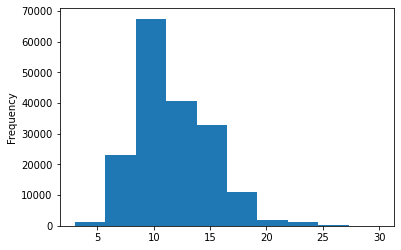

In [13]:
train_df['total_lines'].plot.hist()

## Get list of sentences

In [14]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [15]:
train_sentences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) ',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks ',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers ',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) ',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) ']

## Convert labels into numbers

### One hot encode labels


In [16]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Encode labels using LabelEncoder

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [18]:
# Get classes names and number of classes from LabelEncoder

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Model0: Baseline Model (TF-IDF and Naive Bayes)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('tfidf',TfidfVectorizer(max_features=10000)),
    ('nb', MultinomialNB())
])

pipe.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('nb', MultinomialNB())])

In [20]:
pipe.score(val_sentences, val_labels_encoded)

0.7479809347279227

In [21]:
baseline_preds = pipe.predict(val_sentences)

In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('f1_score :', f1_score(baseline_preds, val_labels_encoded, average='weighted'))
print('Precision :', precision_score(baseline_preds, val_labels_encoded,average='weighted'))
print('Recall :', recall_score(baseline_preds, val_labels_encoded, average='weighted'))

f1_score : 0.756949144394008
Precision : 0.7729382537249844
Recall : 0.7479809347279227


### Conv1 model

**Prepare Text for Deep Sequence models**

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [24]:
#Average length of sentences
len_sentences = [len(sentences.split()) for sentences in train_sentences]
avg_sent_length = np.mean(len_sentences)
print(avg_sent_length)

25.34187958231504


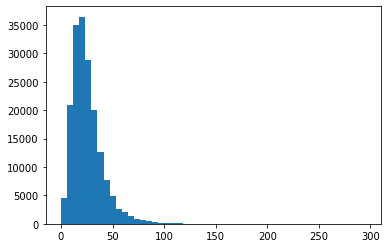

In [25]:
# Distribution of sentence lengths
import matplotlib.pyplot as plt

plt.hist(len_sentences, bins=50)
plt.show()

In [26]:
output_sequence_length = np.percentile(len_sentences, 95)
output_sequence_length

54.0

In [27]:
print('Maxmimum length of Sentence: ',max(len_sentences))

Maxmimum length of Sentence:  295


### Create TextVectorizer Layer

In [28]:
max_tokens = 68000 #Mentioned in the Research Paper

In [29]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, output_sequence_length= int(output_sequence_length))

In [30]:
text_vectorizer.adapt(train_sentences)

In [31]:
import random
target_sentence = random.choice(train_sentences)

print('Text :', target_sentence)
print('Length of Sentence: ', len(target_sentence))
print('Vectorized text: ', text_vectorizer([target_sentence]))

Text : Neuropathic pain is a condition resulting from injury to the peripheral and/or central nervous system 
Length of Sentence:  102
Vectorized text:  tf.Tensor(
[[4763   65   20    8  424 1486   27  503    6    2  838  727  681 3473
   355    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 54), dtype=int64)


In [32]:
rct_text_vocab = text_vectorizer.get_vocabulary()

print('Number of words in vocab: ', len(rct_text_vocab))
print('Most common words in vocab: ', rct_text_vocab[:5])
print('Least common words in vocab: ', rct_text_vocab[-5:])

Number of words in vocab:  64884
Most common words in vocab:  ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab:  ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 54,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom Text embedding

In [34]:
token_embed = layers.Embedding(input_dim = len(rct_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = 'token_embeding')

In [35]:
print(f'Sentence Before Vectiorization: \n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after Vectorization: \n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding: \n {embedded_sentence}\n')
print('Embedded sentence shape:', embedded_sentence.shape)

Sentence Before Vectiorization: 
 Neuropathic pain is a condition resulting from injury to the peripheral and/or central nervous system 

Sentence after Vectorization: 
 [[4763   65   20    8  424 1486   27  503    6    2  838  727  681 3473
   355    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding: 
 [[[-0.02925888  0.03387828  0.01047575 ...  0.01462782  0.02746012
   -0.03121673]
  [-0.00033834 -0.0463096  -0.01810903 ... -0.03448116 -0.02559562
   -0.02689824]
  [ 0.03135607 -0.03761456  0.03394577 ... -0.0432168  -0.02884756
   -0.04918745]
  ...
  [-0.03668591  0.02862842  0.04278504 ... -0.00929791 -0.04965128
    0.03249947]
  [-0.03668591  0.02862842  0.04278504 ... -0.00929791 -0.04965128
    0.03249947]
  [-0.03668591  0.02862842  0.04278504 ... -0.00929791 -0.04965128
    0.03249947]]]

Embedded sente

### Creating dataset (Making sure data loads as fast as possible)

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##Model1: Conv1D with Text Embeddings

In [38]:
from tensorflow.keras import layers
import tensorflow as tf

In [39]:
inputs = layers.Input(shape=(1,), dtype= tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = layers.Conv1D(64, kernel_size=5, padding="same", activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model1 = tf.keras.Model(inputs, outputs)
model1.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])


In [40]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 54)               0         
 torization)                                                     
                                                                 
 token_embeding (Embedding)  (None, 54, 128)           8305152   
                                                                 
 conv1d (Conv1D)             (None, 54, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [41]:
# Fit the model
history_model1 = model1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data= val_dataset,
                            validation_steps = int(0.1*len(val_dataset))) #Only validate on 10% for validation dataset

Epoch 1/3
562/562 [==============================] - 17s 9ms/step - loss: 0.9230 - accuracy: 0.6377 - val_loss: 0.6771 - val_accuracy: 0.7420
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6462 - accuracy: 0.7639 - val_loss: 0.6246 - val_accuracy: 0.7743
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6087 - accuracy: 0.7787 - val_loss: 0.5923 - val_accuracy: 0.7862


In [42]:
model1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5911 - accuracy: 0.7891


[0.5911048650741577, 0.78912353515625]

In [43]:
model1_pred_probs = model1.predict(val_dataset)
model1_pred_probs

array([[5.1428187e-01, 1.2619141e-01, 4.6348885e-02, 2.9658520e-01,
        1.6592721e-02],
       [3.7704358e-01, 3.5649237e-01, 1.4003028e-02, 2.3898090e-01,
        1.3480096e-02],
       [1.5171492e-01, 3.5525488e-03, 1.7043591e-03, 8.4299237e-01,
        3.5768891e-05],
       ...,
       [1.2588308e-05, 1.0204775e-03, 6.6477334e-04, 6.4743094e-06,
        9.9829572e-01],
       [3.6345072e-02, 4.9259284e-01, 7.7980496e-02, 4.1447379e-02,
        3.5163426e-01],
       [1.8312460e-01, 6.9935828e-01, 4.7136746e-02, 4.3040708e-02,
        2.7339652e-02]], dtype=float32)

In [44]:
model1_preds = tf.argmax(model1_pred_probs, axis=1)
model1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [45]:
#Calculate model1 results

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print(accuracy_score(val_labels_encoded, model1_preds ))
print(f1_score(val_labels_encoded, model1_preds, average='weighted'))
print(confusion_matrix(val_labels_encoded, model1_preds))

0.7891235270753343
0.786915890290659
[[1780  679  267  680   43]
 [ 362 3388  165  112  555]
 [ 113  167 8713  138  833]
 [ 495  251  170 1431   29]
 [  29  506  767   10 8529]]


## Model2: Feature Extraction with pre-trained token embeddings
*Universal Sentence Encoder (USE)* : https://tfhub.dev/google/universal-sentence-encoder/4



In [46]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [47]:
#Test out pre-trained embedding on random sentences
random_train_sentence = random.choice(train_sentences)
print(f'Random Training Sentence: {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentece after embedding:\n{use_embedded_sentence}')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random Training Sentence: setting : Multicenter clinical trial conducted in @ centers in the United States and Europe 
Sentece after embedding:
[[ 2.99082045e-03  7.49641210e-02 -3.34704667e-02 -9.90457088e-03
   1.33783993e-04 -3.90686952e-02  4.47808839e-02 -4.98807356e-02
   2.92305034e-02 -4.20445465e-02  7.96118379e-02  4.82283235e-02
   8.20240006e-02 -5.43071851e-02  5.12272716e-02  6.87403977e-02
  -8.01597461e-02  2.58523971e-02  4.97840904e-02  7.28263892e-03
  -2.21467316e-02 -6.94282204e-02 -3.37290391e-02  2.18461193e-02
  -4.24872562e-02 -3.92959863e-02  4.80337953e-03  8.38591307e-02
   3.94256376e-02  6.72276914e-02 -8.96786992e-03  9.61157754e-02
   7.03361034e-02  8.03262815e-02  2.44963355e-02  7.22384593e-03
  -3.45053114e-02 -5.02467379e-02  7.82222580e-03 -3.58810723e-02
  -1.37214921e-02  2.03420650e-02 -8.10506754e-03 -3.63992229e-02
   4.90847006e-02 -1.99793875e-02 -4.44773585e-03 -1.47555461e-02
  -8.14877450e-03 -4.60995622e-02  8.99542589e-04  5.41895665e-0

### Building and fitting feature extraction model from TensorFlow Hub

In [48]:
# Define feature extraction model using TF Hub Layer
inputs = layers.Input(shape=[], dtype= tf.string)
pretrain_embedding = tf_hub_embedding_layer(inputs) #Tokenize text and create embedding od each sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrain_embedding)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model2 = tf.keras.Model(inputs, outputs, name='model2_use_feature_extractor')

model2.compile(loss='categorical_crossentropy',
               optimizer= tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [49]:
model2.summary()

Model: "model2_use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [50]:
# Fit model2 to the data
history_model2 = model2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch= int(0.1* len(train_dataset)),
                            validation_data= val_dataset,
                            validation_steps= int(0.1* len(val_dataset)))


Epoch 1/3
562/562 [==============================] - 12s 17ms/step - loss: 0.9152 - accuracy: 0.6467 - val_loss: 0.7930 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7672 - accuracy: 0.7013 - val_loss: 0.7524 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7496 - accuracy: 0.7119 - val_loss: 0.7372 - val_accuracy: 0.7131


In [51]:
model2.evaluate(val_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.7398 - accuracy: 0.7157


[0.7398321628570557, 0.7156758904457092]

In [52]:
# Make predictions
model2_pred_probs = model2.predict(val_dataset)
model2_pred_probs

array([[4.5238477e-01, 3.5743639e-01, 1.7177041e-03, 1.8105055e-01,
        7.4106236e-03],
       [3.7411198e-01, 4.6488139e-01, 3.2853985e-03, 1.5480396e-01,
        2.9173463e-03],
       [2.4944071e-01, 1.2829098e-01, 1.6394224e-02, 5.6260592e-01,
        4.3268185e-02],
       ...,
       [1.9817243e-03, 5.6527960e-03, 5.5161625e-02, 8.0477935e-04,
        9.3639904e-01],
       [4.0204539e-03, 4.6575550e-02, 2.2205445e-01, 1.3540910e-03,
        7.2599542e-01],
       [1.5092161e-01, 2.8482625e-01, 5.0209081e-01, 6.1609508e-03,
        5.6000393e-02]], dtype=float32)

In [53]:
# Convert predictions probabilities with feature extraction model to labels
model2_preds = tf.argmax(model2_pred_probs, axis=1)
model2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [54]:
# Calculate results
print(accuracy_score(val_labels_encoded, model2_preds ))
print(f1_score(val_labels_encoded, model2_preds, average='weighted'))
print(confusion_matrix(val_labels_encoded, model2_preds))

0.7156758903746856
0.7127680405639829
[[1402 1004  295  640  108]
 [ 307 3091  317  239  628]
 [ 176  327 7906  254 1301]
 [ 319  424  236 1324   73]
 [  51  584 1246   61 7899]]


## Model3 : Conv1D with character embeddings


### Create character level tokenizer


In [55]:
train_sentences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) ',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks ',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers ',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) ',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) ']

In [56]:
#Make function to convert words into characters

def split_chars(text):
  return " ".join(list(text))

split_chars(random_train_sentence)

's e t t i n g   :   M u l t i c e n t e r   c l i n i c a l   t r i a l   c o n d u c t e d   i n   @   c e n t e r s   i n   t h e   U n i t e d   S t a t e s   a n d   E u r o p e  '

In [57]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
test_chars[:5]

['T h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   A D H F   )  ',
 'A   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   E v a l u a t i o n   S t u d y   o f   C o n g e s t i v e   H e a r t   F a i l u r e   a n d   P u l m o n a r y   A r t e r y   C a t h e t e r i z a t i o n   E f f e c t i v e n e s s   (   E S C A P E   )  ',
 'L i v e r   f u n c t i o n   t e s t s   (   L F T s   )   w e r e   m e a s u r e d   a t   @   t i m e   p o i n t s   f r o m   b a s e l i n e   ,   a t   d i s c h a r g e   ,   a n d   u p   t o   @   m o n t h s   f o l l o w - u p  ',
 'S u r v i v a l   a n a l y s e s   w e r e   u s e d   t o   a s s e s s   t h e   a s s o c i a t i o n   b e t w e e n   

In [58]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

148.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   0. ,  138.5,  277. ,  415.5,  554. ,  692.5,  831. ,  969.5,
        1108. , 1246.5, 1385. ]),
 <a list of 10 Patch objects>)

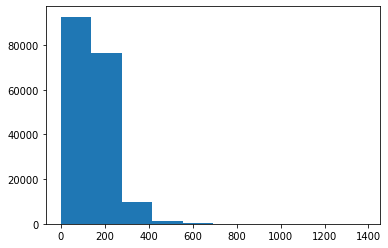

In [59]:
plt.hist(char_lens, bins=10)

In [60]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

289

In [61]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
#char level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 #Added 2 for space and OOV (Out of Vocab, ['UNK'])
char_vectorizer = TextVectorization(max_tokens= NUM_CHAR_TOKENS,
                  output_sequence_length = output_seq_char_len,
                  name='char_vectorizer')


In [63]:
#Adapt character vectiorizer to training characters
char_vectorizer.adapt(train_chars)

In [64]:
#Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]} ')
print(f'5 least common characters: {char_vocab[-5:]} ')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i'] 
5 least common characters: ['k', 'x', 'z', 'q', 'j'] 


In [65]:
#Test character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Text in characters: {random_train_chars}')
print(f'Length of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'Vecotrized chars:\n{vectorized_chars}')
print(f'Length of vectorized chars: {len(vectorized_chars[0])}')

Text in characters: T h e   O C N   +   c e l l s   l a c k i n g   b o t h   C D @   a n d   C D @   i n c r e a s e d   f r o m   w e e k s   @   t o   @   (   @   @   t o   @   @   %   ;   P   =   @   )   ,   b u t   r e t u r n e d   t o   b a s e l i n e   a f t e r   s w i t c h i n g   t o   M E T  
Length of random_train_chars: 108
Vecotrized chars:
[[ 3 13  2  7 11  6 11  2 12 12  9 12  5 11 23  4  6 18 22  7  3 13 11 10
   5  6 10 11 10  4  6 11  8  2  5  9  2 10 17  8  7 15 20  2  2 23  9  3
   7  3  7 14 22 16  3  8  2  3 16  8  6  2 10  3  7 22  5  9  2 12  4  6
   2  5 17  3  2  8  9 20  4  3 11 13  4  6 18  3  7 15  2  3  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Creating character-level Embedding

In [66]:
char_embed = layers.Embedding(input_dim=len(char_vocab), 
                 output_dim=25,
                 mask_zero=True,
                 name = 'char_embed')

In [67]:
#Test Character embedding layer
print(f'Text characters before vectiorization: {random_train_chars}')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Text character after vecotrization:\n {char_embed_example}\n')
print(f'char_embed shape: {char_embed_example.shape}')

Text characters before vectiorization: T h e   O C N   +   c e l l s   l a c k i n g   b o t h   C D @   a n d   C D @   i n c r e a s e d   f r o m   w e e k s   @   t o   @   (   @   @   t o   @   @   %   ;   P   =   @   )   ,   b u t   r e t u r n e d   t o   b a s e l i n e   a f t e r   s w i t c h i n g   t o   M E T  
Text character after vecotrization:
 [[[-0.00204003  0.03275463 -0.04107921 ... -0.03794665 -0.01051033
   -0.00838289]
  [-0.00809946  0.02626615 -0.03704773 ...  0.00267907  0.01120151
    0.04317466]
  [ 0.03029663  0.02438969  0.03811285 ...  0.04896033 -0.00350209
    0.02064573]
  ...
  [ 0.0435933  -0.03385031  0.03983606 ...  0.02988741  0.01416875
    0.03464403]
  [ 0.0435933  -0.03385031  0.03983606 ...  0.02988741  0.01416875
    0.03464403]
  [ 0.0435933  -0.03385031  0.03983606 ...  0.02988741  0.01416875
    0.03464403]]]

char_embed shape: (1, 289, 25)


### Build Conv1D model to fit on character embeddings

In [68]:
#Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5,padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model3 = tf.keras.Model(inputs, outputs,
               name='model3_char_embedding_conv1d')

model3.compile(loss='categorical_crossentropy',
               optimizer= tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [69]:
model3.summary()

Model: "model3_char_embedding_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 289)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 289, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 289, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)

In [70]:
# Create char-level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
model3_history = model3.fit(train_char_dataset,
                            epochs=3,
                            steps_per_epoch = int(0.1* len(train_char_dataset)),
                            validation_data = val_char_dataset,
                            validation_steps = int(0.1* len(val_char_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2503 - accuracy: 0.4895 - val_loss: 1.0390 - val_accuracy: 0.5785
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0101 - accuracy: 0.5958 - val_loss: 0.9386 - val_accuracy: 0.6333
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9310 - accuracy: 0.6357 - val_loss: 0.8703 - val_accuracy: 0.6636


In [72]:
# Make predictions with character model only
model3_pred_probs = model3.predict(val_char_dataset)
model3_pred_probs

array([[0.10694952, 0.3171096 , 0.13429849, 0.4057761 , 0.03586632],
       [0.21340056, 0.38809568, 0.01280854, 0.3504427 , 0.0352525 ],
       [0.11092953, 0.3494761 , 0.0960571 , 0.37136328, 0.07217397],
       ...,
       [0.01960384, 0.01780817, 0.09545702, 0.02791664, 0.83921427],
       [0.01539798, 0.08649106, 0.46902943, 0.03457112, 0.39451042],
       [0.48738408, 0.35184106, 0.09737788, 0.05582593, 0.00757116]],
      dtype=float32)

In [73]:
# Convert prediction probabilities to class labels
model3_preds = tf.argmax(model3_pred_probs, axis=1)
model3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 2, 0])>

In [74]:
# Calculate results
print(accuracy_score(val_labels_encoded, model3_preds ))
print(f1_score(val_labels_encoded, model3_preds, average='weighted'))
print(confusion_matrix(val_labels_encoded, model3_preds))


0.6507017079306235
0.6409664756538673
[[ 898 1024  541  737  249]
 [ 411 2178  554  509  930]
 [ 194  297 8178  215 1080]
 [ 235  550  355 1083  153]
 [  88  578 1747  106 7322]]


## Model4: Combining pretrained token embedding + characters embedding (hybrid)

1. Token-level Embedding (similar to `model 2`)
2. Character-level Embedding (similar to `model 3` with little modification)
3. Combine 1 & 2 with a concatenate (`layers.concatenate`)
4. Build a series of output layer on top of 3
5. Construct a model which takes token and character-level embedding as input and sequences label probabilities as output 

In [75]:
#1. Setup token inputs /model

token_inputs = layers.Input([], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs= token_inputs,
               outputs= token_outputs)

#2. Setup character inputs/model
char_inputs = layers.Input(shape= (1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #bi-LSTM 

char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Concatenate token and char inputs (create hybrid token embeddings)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, 
                                                                    char_model.output])

#4. Create output layers - Adding Dropout layer

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)


#5. Construct model with char and token inputs

model4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layer,
                        name='model4_token_and_char_embeddings')



In [76]:
# Get a summary of model4
model4.summary()

Model: "model4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 289)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

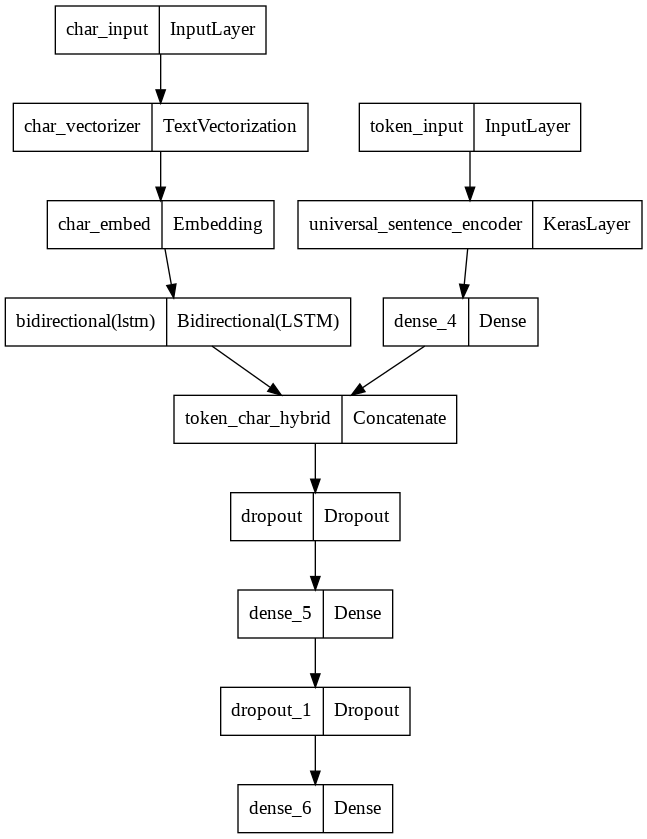

In [77]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model4)

In [78]:
# Comiple model
model4.compile(loss='categorical_crossentropy',
               optimizer= tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

### Combining token and character dataset  into a tf.data dataset

In [79]:
#Combine chars and tokens into dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #Make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))  #Combine data and labels

#Prefetch and batch train dataset
train_char_token_dataset= train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [80]:
#Combine chars and tokens into dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #Make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))  #Combine data and labels

#Prefetch and batch val dataset
val_char_token_dataset= val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
#Check train char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting the model on token and character-level embeddings

In [82]:
history_model4 = model4.fit(train_char_token_dataset,
                            steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                            epochs=3,
                            validation_data = val_char_token_dataset,
                            validation_steps= int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 58ms/step - loss: 0.9898 - accuracy: 0.6065 - val_loss: 0.7854 - val_accuracy: 0.6948
Epoch 2/3
562/562 [==============================] - 29s 51ms/step - loss: 0.8052 - accuracy: 0.6896 - val_loss: 0.7186 - val_accuracy: 0.7261
Epoch 3/3
562/562 [==============================] - 34s 61ms/step - loss: 0.7772 - accuracy: 0.7057 - val_loss: 0.6913 - val_accuracy: 0.7397


In [83]:
#Evaluate model on whole validation dataset
model4.evaluate(val_char_token_dataset)

945/945 [==============================] - 37s 39ms/step - loss: 0.6968 - accuracy: 0.7358


[0.6967586874961853, 0.7357672452926636]

In [84]:
#Make predictions using the token-character model
model4_pred_probs = model4.predict(val_char_token_dataset)
model4_pred_probs

array([[4.07879591e-01, 3.88982743e-01, 1.00308368e-02, 1.82834923e-01,
        1.02718994e-02],
       [3.50467741e-01, 4.75861847e-01, 7.31810229e-03, 1.63783759e-01,
        2.56852829e-03],
       [2.66983181e-01, 1.50938943e-01, 7.89309740e-02, 4.61312711e-01,
        4.18340378e-02],
       ...,
       [1.35990593e-03, 1.13784131e-02, 5.59920371e-02, 3.99972923e-04,
        9.30869639e-01],
       [1.11461785e-02, 8.21119919e-02, 2.41234258e-01, 4.95079160e-03,
        6.60556853e-01],
       [3.45413953e-01, 3.49636734e-01, 2.37357229e-01, 3.34729552e-02,
        3.41191553e-02]], dtype=float32)

In [85]:
#Make labels from probabilities
model4_preds = tf.argmax(model4_pred_probs, axis=1)
model4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [86]:
# Calculate results
print(accuracy_score(val_labels_encoded, model4_preds ))
print(f1_score(val_labels_encoded, model4_preds, average='weighted'))
print(confusion_matrix(val_labels_encoded, model4_preds))

0.7357672448033894
0.7328374460020198
[[1456 1111  268  524   90]
 [ 320 3208  296  130  628]
 [ 230  308 8253  142 1031]
 [ 359  418  198 1360   41]
 [  55  569 1226   39 7952]]


##Model5: Transfer Learning with pretrained token embedding + Character embedding + Positional embedding

In [87]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11


### Create Positional Embeddings

In [88]:
# Number of different line numbers
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

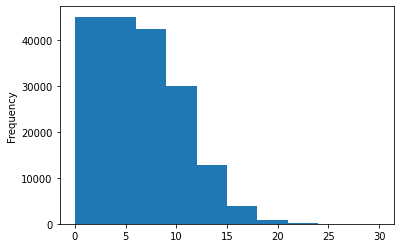

In [89]:
#Check Distribution of 'line number' column
train_df['line_number'].plot.hist()

In [90]:
#Use TensorFlow to create one-hot encoded tensors of 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)


train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [91]:
#Number of different number of lines (length of abstract)
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

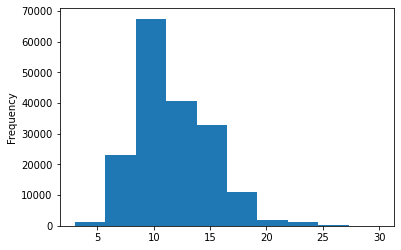

In [92]:
#Check distribution of 'total_lines'
train_df['total_lines'].plot.hist()

In [93]:
#Check the coverage of 'total_lines' value of 20
np.percentile(train_df['total_lines'], 98)

20.0

In [94]:
#Use TensorFlow to create one hot encoded tensors for 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Create Tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for 'line_number' feature
4. Create a model for 'total_lines' feature
5. Combine outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine outputs of 3, 4, & 5 using tf.keras.layers.Concatenate
7. Create output layer to accept tribrid embeddings and output label probabilities
8. Combine inputs 1,2,3,4 and outputs into tf.keras.Model 

In [95]:
#1. Token Inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs= token_inputs,
               outputs= token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs= char_inputs,
                            outputs=char_bi_lstm)

#3. Line number model
line_num_inputs = layers.Input(shape=(15,), dtype= tf.float32, name='line_num_inputs')
line_num_outputs = layers.Dense(32, activation='relu')(line_num_inputs)
line_num_model = tf.keras.Model(inputs=line_num_inputs,
               outputs=line_num_outputs)

#4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype= tf.float32, name='total_lines_inputs')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs= total_lines_inputs,
                                   outputs= total_lines_outputs)

#5. Combine token and char embeddings into a hybrid embeddings
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output, char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_postional_embedding')([line_num_model.output,
                                                                               total_lines_model.output,
                                                                                z])

#7. Create output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

#8. Put together model with all kind of inputs
model5 = tf.keras.Model(inputs=[line_num_model.input, 
                                total_lines_model.input, 
                                token_model.input,
                                char_model.input],
                        outputs= output_layer,
                        name= 'model5_tribrid_embedding_model')

In [96]:
# Get the summary of Tribird embedding model
model5.summary()

Model: "model5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 289)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['to

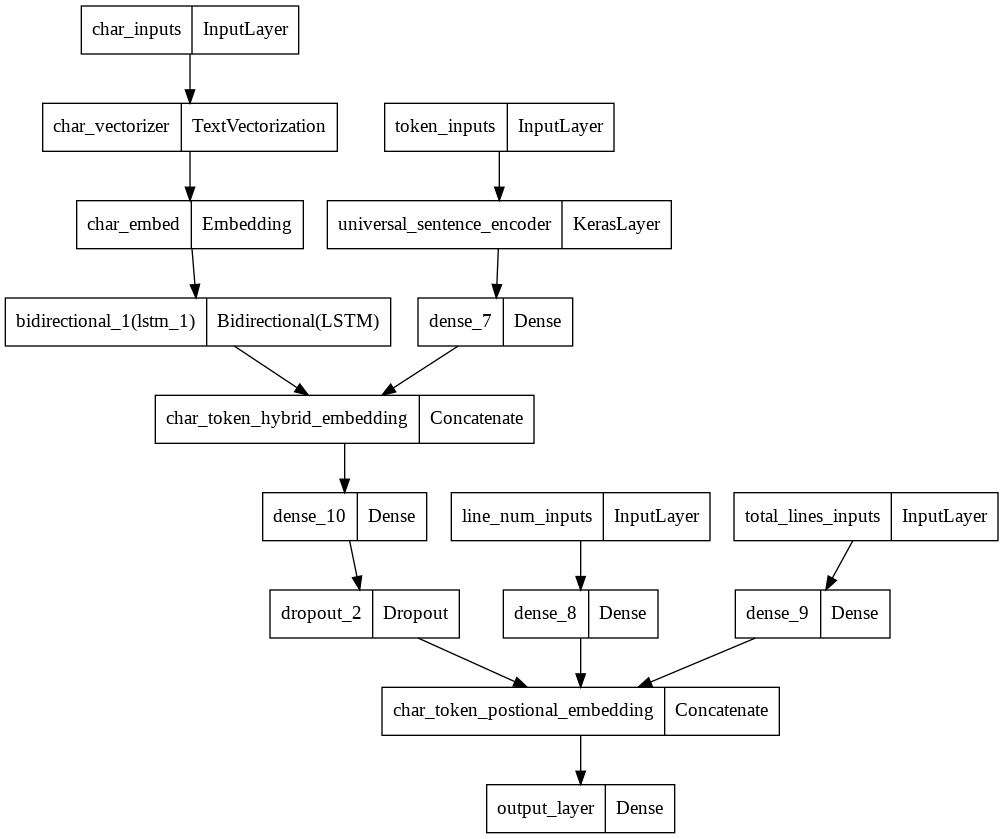

In [97]:
plot_model(model5)

In [98]:
# Compile token char positional embedding model

model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3), #label_smoothing helps to prevent overfitting
               optimizer= tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [99]:
# Create tribrid embedding dataset using tf.data

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                             train_total_lines_one_hot,
                                                            train_sentences, train_chars)) # Make data

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))                                                           

#Prefetch and batch train dataset
train_char_token_pos_dataset= train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [100]:
# Do the same as above for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                             val_total_lines_one_hot,
                                                            val_sentences, val_chars)) # Make data

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))                                                           

#Prefetch and batch train dataset
val_char_token_pos_dataset= val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_dataset


<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fitting and evaluating tribrid model 

In [101]:
history_model5 = model5.fit(train_char_token_pos_dataset,
                            steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                            epochs=3,
                            validation_data = val_char_token_pos_dataset,
                            validation_steps= int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 68s 95ms/step - loss: 1.2185 - accuracy: 0.7259 - val_loss: 1.1343 - val_accuracy: 0.8072
Epoch 2/3
562/562 [==============================] - 44s 78ms/step - loss: 1.1235 - accuracy: 0.8171 - val_loss: 1.1108 - val_accuracy: 0.8258
Epoch 3/3
562/562 [==============================] - 28s 49ms/step - loss: 1.1113 - accuracy: 0.8234 - val_loss: 1.1008 - val_accuracy: 0.8311


In [102]:
#Evaluate model5
model5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 25s 27ms/step - loss: 1.0998 - accuracy: 0.8326


[1.0998198986053467, 0.832649290561676]

In [103]:
model5_pred_probs = model5.predict(val_char_token_pos_dataset)
model5_pred_probs

array([[0.49293494, 0.14734788, 0.0258083 , 0.30228952, 0.03161933],
       [0.47516906, 0.13722494, 0.07215965, 0.29098025, 0.02446603],
       [0.26032665, 0.13693555, 0.1824296 , 0.32194474, 0.0983635 ],
       ...,
       [0.05201695, 0.12198702, 0.05743237, 0.04776781, 0.72079587],
       [0.04412271, 0.3200669 , 0.10274816, 0.04354412, 0.48951808],
       [0.25146574, 0.48899502, 0.12186047, 0.06026236, 0.07741636]],
      dtype=float32)

In [104]:
model5_preds = tf.argmax(model5_pred_probs, axis=1)
model5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [105]:
# Calculate results
print(accuracy_score(val_labels_encoded, model5_preds ))
print(f1_score(val_labels_encoded, model5_preds, average='weighted'))
print(confusion_matrix(val_labels_encoded, model5_preds))

0.832649278432411
0.8314190385035823
[[2575   91  287  486   10]
 [  69 3862   49    0  602]
 [ 121  255 8775   46  767]
 [ 826    6  160 1381    3]
 [  13  552  711    2 8563]]


In [106]:
## Compare model results

def calculate_results(actual, pred):
  acc = accuracy_score(actual, pred )
  f1 =  f1_score(actual, pred, average='weighted')
  pre = precision_score(actual, pred, average='weighted')
  recall = recall_score(actual, pred, average='weighted')
  return acc, f1, pre, recall

In [107]:

model0_results = calculate_results(val_labels_encoded, baseline_preds )

model1_results = calculate_results(val_labels_encoded, model1_preds )

model2_results = calculate_results(val_labels_encoded, model2_preds )

model3_results = calculate_results(val_labels_encoded, model3_preds )

model4_results = calculate_results(val_labels_encoded, model4_preds )

model5_results = calculate_results(val_labels_encoded, model5_preds )

results = pd.DataFrame({'Baseline_model0': model0_results,
             'model1_custom_token_embeddings': model1_results,
              'model2_pretrained_token_embeddings':model2_results,
              'model3_custom_char_embeddings':model3_results,
              'model4_hybrid_char_token_embeddings':model4_results,
              'model5_char_token_pos_embeddings': model5_results}, ['Accuracy','f1_score','Precision','Recall']).T
results

,Accuracy,f1_score,Precision,Recall
Baseline_model0,0.747981,0.739013,0.740950,0.747981
model1_custom_token_embeddings,0.789124,0.786916,0.786680,0.789124
model2_pretrained_token_embeddings,0.715676,0.712768,0.716467,0.715676
model3_custom_char_embeddings,0.650702,0.640966,0.641800,0.650702
model4_hybrid_char_token_embeddings,0.735767,0.732837,0.735738,0.735767
model5_char_token_pos_embeddings,0.832649,0.831419,0.831565,0.832649


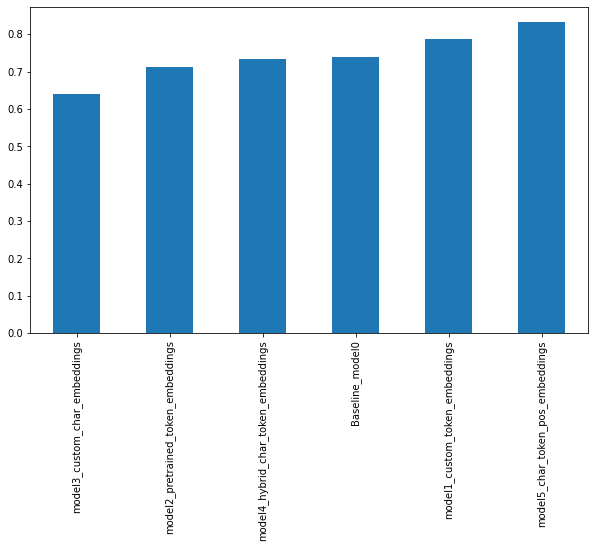

In [108]:
results.sort_values(by='f1_score')['f1_score'].plot(kind='bar', figsize=(10,6))

## Save and load Model

In [109]:
#Save the best performing model
model5.save('skimlit_tribrid')

INFO:tensorflow:Assets written to: skimlit_tribrid/assets


INFO:tensorflow:Assets written to: skimlit_tribrid/assets


In [111]:
#Load the same model
loaded_model = tf.keras.models.load_model('skimlit_tribrid')

In [112]:
#Make predictions with loaded model
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [113]:
calculate_results(val_labels_encoded, loaded_preds)

(0.832649278432411, 0.8314190385035823, 0.831564740952276, 0.832649278432411)

In [114]:
model5_results

(0.832649278432411, 0.8314190385035823, 0.831564740952276, 0.832649278432411)

In [115]:
loaded_model.summary()

Model: "model5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 289)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['to